# Imports

In [36]:
import os
import numpy as np
import skimage
import pandas as pd
import seaborn as sns
import os
import warnings
import cv2
import math
import itertools
import re
import matplotlib.pyplot as plt
import imageio

from scipy.spatial import distance_matrix
from sklearn.metrics import pairwise_distances

import matplotlib.cm as cm
import matplotlib.animation as animation

from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage



# Hiperparametros

In [40]:
# PARAMETROS GENERALES

# Camino al video a aplicar proceso
PATH = '../data/02_Pg_65_CB.tif'

# Mostrar o no videos del proceso (Renderizar los videos es lo que mas tiempo consume)
PLOT_VIDEOS = False


# PARAMETROS DEL FILTADO

# Tamaño en pixeles maximo y minimo
TAMAÑO_MINIMO = 14
TAMAÑO_MAXIMO = 100

# Distancia minima en pixeles entre dos elipses 
DISTANCIA_MINIMA = 30

# Cantidad de frames que debe aparecer al menos
APARICIONES_MINIMAS = 5


# PARAMETROS DE CABEZA
TAMANO_CABEZA = 20

# PARAMETROS DE LA DETECCION 
THRESHOLD_AR = 0.5

'''
RECOMENDACIONES:

- En caso de que la cantidad de elipses encontradas sea menor que la cantidad en el video, ser más laxo con los
parametros del fitlrado (aumentar DISTANCIA_MINIMA, disminuir APARICIONES_MINIMAS, etc). En caso que el algoritmo
alucine elipses, hacer lo contrario.

- En caso que el video con el que se trabaje tenga elipses de tamaños en pixeles distintos al del ejemplo, ajustar
TAMAÑO_MINIMO y TAMAÑO_MAXIMO de forma que el tamaño promedio del espermatozoide este dentro de este rango, y luego
ajustar TAMANO_CABEZA de forma que sea un circulo con este radio sea aproximadamente el tamaño de la cabeza

- Recomendamos no cambiar THRESHOLD_AR de 0.5, ya que este fue determinado luego de un estudio en una tesis de 
maestria, sin embargo en caso de que el algoritmo sea muy permisivo con las reacciones que encuentra, o viceversa,
se puede aumentar o disminuir este valor
'''

print('')

# Levantar Data

In [41]:
# Descargar Video

images = imageio.imread(PATH)

canal_fluo_ext = images[:, 1]
canal_membrana_ext = images[:, 0]

In [42]:
# La data se trandforma de uint16 a unit8

canal_fluo = np.zeros(shape=canal_fluo_ext.shape).astype("uint8")
for i,img in enumerate(canal_fluo_ext):
  new_img = (img / 65535 * 256).astype("uint8")
  canal_fluo[i] = new_img

canal_membrana = np.empty(shape=canal_membrana_ext.shape).astype("uint8")
for i,img in enumerate(canal_membrana_ext):
  new_img = (img / 65535 * 256).astype("uint8")
  canal_membrana[i] = new_img

In [43]:
# Graficar canal Fluo

if PLOT_VIDEOS:
    fps = 10
    nmbr_frames = canal_fluo.shape[0] - 1
    duration = int(nmbr_frames/fps)

    fig, ax = plt.subplots()

    def make_frame(t):
      ax.clear()
      idx = int(t*fps)
      img = canal_fluo[idx]
      ax.imshow(img,cmap="gray")
      return mplfig_to_npimage(fig)


    first_animation = VideoClip(make_frame, duration = duration)
    first_animation.ipython_display(fps = 10, loop = True, autoplay = True)

In [44]:
# Graficar canal Membrana

if PLOT_VIDEOS:
    fps = 10
    nmbr_frames = canal_fluo.shape[0] - 1
    duration = int(nmbr_frames/fps)

    fig, ax = plt.subplots()

    def make_frame(t):
      ax.clear()
      idx = int(t*fps)
      img = canal_membrana[idx]
      ax.imshow(img,cmap="gray")
      return mplfig_to_npimage(fig)

    first_animation = VideoClip(make_frame, duration = duration)
    first_animation.ipython_display(fps = 10, loop = True, autoplay = True)

# Funciones de Ploteo Auxiliares


In [45]:
def ellipses_on_image(elipses,imagen,solo_centros,segundos_centros=None,centros_dobles=False):
  rgb_img = cv2.cvtColor(imagen,cv2.COLOR_GRAY2RGB)
  for idx,elps in enumerate(elipses):
    if solo_centros:
      if elps[0] != None:
        elps = ((elps[0],elps[1]),(20,20),0)
        if centros_dobles:
          elps_2 = segundos_centros[idx]
          elps_2 = ((elps_2[0],elps_2[1]),(20,20),0)
      else:
        elps = None
        if centros_dobles:
          elps_2 = None
    if elps != None:
      rgb_img = cv2.ellipse(rgb_img, elps, (10,0,0), 2)
      if centros_dobles:
        rgb_img = cv2.ellipse(rgb_img, elps_2, (0,0,10), 2)
  return rgb_img

def video_ellises_on_image(elipses,imagenes,solo_centros=False,segundos_centros=None,centros_dobles=False):
  fps = 10
  nmbr_frames = imagenes.shape[0] - 1
  duration = int(nmbr_frames/fps)

  fig, ax = plt.subplots()

  def make_frame(t):
    ax.clear()
    idx = int(t*fps)
    elps = elipses[idx]
    if not centros_dobles:
      img_w_elps = ellipses_on_image(elps,imagenes[idx],solo_centros=solo_centros)
    else:
      img_w_elps = ellipses_on_image(elps,imagenes[idx],solo_centros=solo_centros,segundos_centros=segundos_centros[idx],centros_dobles=True)
    ax.imshow(img_w_elps*25)
    return mplfig_to_npimage(fig)

  animation = VideoClip(make_frame, duration = duration)
  return animation


def ellipses_reaccion(elipses,imagen,idx_reaccion):
  rgb_img = cv2.cvtColor(imagen,cv2.COLOR_GRAY2RGB)
  for idx,elps in enumerate(elipses):
    color = (10,0,0)
    if idx in idx_reaccion:
        color=(0,10,0)
    elps = ((elps[0],elps[1]),(20,20),0)
    rgb_img = cv2.ellipse(rgb_img, elps, color, 2)
  return rgb_img

def video_reaccion(centros,imagenes,idx_reaccion):
  fps = 10
  nmbr_frames = imagenes.shape[0] - 1
  duration = int(nmbr_frames/fps)

  fig, ax = plt.subplots()

  def make_frame(t):
    ax.clear()
    idx = int(t*fps)
    ctr = centros[idx]
    img_w_elps = ellipses_reaccion(ctr,imagenes[idx],idx_reaccion)
    ax.imshow(img_w_elps*25)
    return mplfig_to_npimage(fig)

  animation = VideoClip(make_frame, duration = duration)
  return animation

# Calcular y Trackear Elipses de todas las Imagenes

In [46]:
# Obtener Centros a partir de una Elipse
def get_centers(elps):
  centers = []
  for idx, el in enumerate(elps):
    if el != None:
      centers.append(np.array(el[0]))
    else:
      centers.append(np.array([None,None]))
  return np.array(centers)

# Aplciar Mascara a Imagen
def mask_img(img):
  _, threshold = cv2.threshold(img,0, 255, cv2.THRESH_OTSU)
  kernel = np.ones((3,3), np.uint8)
  mask = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, kernel).astype(np.uint8)
  return mask

# Dibujar Elipses en Imagen
def draw_ellipses(img):
  contours , _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  negro = np.zeros(img.shape)
  ellipses = []
  for contour in contours:
    if len(contour) >= 5:
      elipse = cv2.fitEllipse(contour)
      ellipses.append(elipse)
      negro = cv2.ellipse(negro, elipse, 255, 2)
  return negro, ellipses

In [47]:
# INICIALIZACION CON PRIMERA IMAGEN
first_img = canal_fluo[0]
masked = mask_img(first_img)
img_elips, elips = draw_ellipses(masked)
total_elipses = len(elips)
elips_2 = np.empty(total_elipses, dtype=object)
for i,j in enumerate(elips):
  elips_2[i] =  j
ellipse_matrix = [elips_2]
centers_matrix = [get_centers(elips)]

# PARA CADA IMAGEN
for img in canal_fluo[1:]:

  # PROCESAR Y OBTENER ELIPSE
  masked = mask_img(img)
  img_elips, elips = draw_ellipses(masked)

  # OBTENER CENTROS PARA COMPARAR
  prev_centers = centers_matrix[-1]
  curr_centers = get_centers(elips)

  # HALAR CENTRO VIEJO MAS CERCANO PARA CADA CENTRO NUEVO
  distances = distance_matrix(curr_centers, prev_centers)
  new_idx = np.argmin(distances,axis=1)
  # SI LA DISTANCIA ES MAYOR QUE UN UMBRAL, CAMBIAR INDICE POR NUEVO INDICE
  for i,j in enumerate(new_idx):
    if distances[i,j] >= 20:
      new_idx[i] = total_elipses
      total_elipses += 1

  # GENERAR NUEVO ORDEN DE ELIPSES CON NUEVOS INDICES
  elipses_arregladas = np.empty(total_elipses, dtype=object)
  for i,j in enumerate(new_idx):
    elipses_arregladas[j] =  elips[i]

  # GENERAR NUEVO ORDEN DE CENTROS. ELIPSES QUE EXPLOTAN QUEDA CON CENTRO PASADO
  centers_arreglados = get_centers(elipses_arregladas)
  for idx,c in enumerate(centers_arreglados):
    if (c == None).any():
      centers_arreglados[idx] = prev_centers[idx]

  # GUARDAR EN REGISTROS
  ellipse_matrix.append(elipses_arregladas)
  centers_matrix.append(centers_arreglados)

In [48]:
# RELLENAR MOMENTOS QUE NO APARECEN ELIPSES CON NONE PARA TENER TENSOR

def pad_centers(lista):
  max_len = 0
  for arr in lista:
    if len(arr) > max_len:
      max_len = len(arr)
  for idx,arr in enumerate(lista):
    if len(arr) < max_len:
      padd = np.empty((max_len-len(arr),2),dtype=object)
      lista[idx] = np.vstack([arr,padd])
  return np.array(lista)

def pad_ellipses(lista):
  max_len = 0
  for arr in lista:
    if len(arr) > max_len:
      max_len = len(arr)
  for idx,arr in enumerate(lista):
    if len(arr) < max_len:
      padd = np.empty((max_len-len(arr)),dtype=object)
      lista[idx] = np.hstack([arr,padd])
  return np.array(lista)


padded_elipses = pad_ellipses(ellipse_matrix)
padded_centres = pad_centers(centers_matrix)

if PLOT_VIDEOS:
    animation = video_ellises_on_image(padded_elipses,canal_fluo)
    animation.ipython_display(fps = 10, loop = True, autoplay = True)

# Filtrar Elipses por Tamaño, Apariciones y Cercania

In [49]:
def filtrado_por_tamano_y_apariciones(padded_elipses, padded_centres, tam_min, tam_max, ap_min):

  new_padded_elipses = np.copy(padded_elipses)
  new_padded_centres = np.copy(padded_centres)

  # Filtrado por tamano
  eliminar = []
  for j in range(new_padded_elipses.shape[1]):
    for i in range(new_padded_elipses.shape[0]):
      if (new_padded_elipses[i][j] is not None):
        norm = np.linalg.norm(new_padded_elipses[i][j][1])
        if (norm < tam_min) or (norm > tam_max):
          new_padded_elipses[i][j] = None
          new_padded_centres[i][j] = None

  # Eliminamos aquellas elipses que sean todo none
  for j in range(new_padded_elipses.shape[1]):
    suma = 0
    for i in range(new_padded_elipses.shape[0]):
      if (new_padded_elipses[i][j] is not None):
        suma += 1
    if suma<ap_min:
        eliminar.append(j)

  h = 0
  for l in eliminar:
    new_padded_elipses = np.delete(new_padded_elipses,l-h,1)
    new_padded_centres = np.delete(new_padded_centres,l-h,1)
    h+=1
  return new_padded_elipses, new_padded_centres

In [50]:
def filtrado_por_cercania(padded_elipses, padded_centres, dis_min, size=9):

  new_padded_elipses = np.copy(padded_elipses)
  new_padded_centres = np.copy(padded_centres)

  #Calculo centros promedios
  centros_prom = []
  for i in range(new_padded_centres.shape[1]):
    l = new_padded_centres[:,i]
    prom = np.mean([x for x in l if x.any() != None],axis=0).tolist()
    centros_prom.append(prom)
  centros_prom = np.array(centros_prom)

  #Hallo los pares
  a = pairwise_distances(centros_prom,centros_prom)
  a = np.tril(a)
  b = np.array(np.where((a<dis_min)&(a>0)))

  #
  eliminar = []
  for i in range(b.shape[1]):
    lum_1 = 0
    lum_2 = 0
    for j in range(canal_fluo.shape[0]):
      l1 = centros_prom[b[0,i]]
      lum_1 += np.sum(canal_fluo[j,int(l1[0])-size:int(l1[0])+size,int(l1[1])-size:int(l1[1])+size])
      l2 = centros_prom[b[1,i]]
      lum_2 += np.sum(canal_fluo[j,int(l2[0])-size:int(l2[0])+size,int(l2[1])-size:int(l2[1])+size])
    if lum_1>=lum_2:
      eliminar.append(b[1,i])
    else:
      eliminar.append(b[0,i])
  new_padded_elipses = np.delete(new_padded_elipses,eliminar,1)
  new_padded_centres = np.delete(new_padded_centres,eliminar,1)
  return new_padded_elipses, new_padded_centres

In [51]:

filtered_elipses, filtered_centres = filtrado_por_tamano_y_apariciones(padded_elipses,padded_centres,tam_min=TAMAÑO_MINIMO,tam_max=TAMAÑO_MAXIMO,ap_min=APARICIONES_MINIMAS)
full_filtered_elipses, full_filtered_centres = filtrado_por_cercania(filtered_elipses, filtered_centres,dis_min=DISTANCIA_MINIMA)


if PLOT_VIDEOS:
    animation_full_filtered = video_ellises_on_image(full_filtered_elipses,canal_fluo)
    animation_full_filtered.ipython_display(fps = 10, loop = True, autoplay = True)

# Rellenar Nones


In [52]:
def fill_none(elipses,centers):
  for j in range(elipses.shape[1]):
    ultimo = elipses[np.where(elipses[:,j]!=None)[0][0],j]
    ultimo_c = centers[np.where(centers[:,j]!=None)[0][0],j]
    for i in range(elipses.shape[0]):
      if elipses[i][j] is not None:
        ultimo = elipses[i][j]
        ultimo_c = centers[i][j]
      elipses[i][j] = ultimo
      centers[i][j] = ultimo_c
  return elipses, centers

In [53]:
filled_ellipses, filled_centros = fill_none(full_filtered_elipses,full_filtered_centres)

if PLOT_VIDEOS:
    animation_filled = video_ellises_on_image(filled_ellipses,canal_fluo)
    animation_filled.ipython_display(fps = 10, loop = True, autoplay = True)


# Obtencion Centro de Cabezas

In [54]:

def devolver_nuevos_centros(punto, angulo,largo=40):
  x, y = punto
  ang = 2*np.pi*(90-angulo)/360
  x1 = x - largo/4*np.cos(ang)
  y1 = y + largo/4*np.sin(ang)
  x2 = x + largo/4*np.cos(ang)
  y2 = y - largo/4*np.sin(ang)
  return (x1,y1),(x2,y2)

def get_ellipse_pixels(center,tam_cab=TAMANO_CABEZA):
  center_y = center[0]
  center_x = center[1]
  height, width = (tam_cab,tam_cab)
  angle_rad = 0
  x_min = center_x - width/2
  x_max = center_x + width/2
  y_min = center_y - height/2
  y_max = center_y + height/2
  x = np.arange(int(x_min), int(x_max),1)
  y = np.arange(int(y_min), int(y_max),1)
  X, Y = np.meshgrid(x, y)
  X_rot = (X - center_x) * np.cos(angle_rad) + (Y - center_y) * np.sin(angle_rad)
  Y_rot = -(X - center_x) * np.sin(angle_rad) + (Y - center_y) * np.cos(angle_rad)
  ellipse_eq = (X_rot / (width / 2)) ** 2 + (Y_rot / (height / 2)) ** 2
  inside_ellipse = ellipse_eq <= 1
  points = np.array([Y[inside_ellipse], X[inside_ellipse]]).T
  return points


def separacion_centros(padded_centres,padded_elipses,canal_fluo):

  centros_nuevos = np.empty(padded_centres.shape)
  centros_cola = np.empty(padded_centres.shape)
  size = 9
  varianza_1 = []
  varianza_2 = []

  for j in range(padded_elipses.shape[1]):
    suma_1 = 0
    suma_2 = 0
    p1 = np.zeros((padded_elipses.shape[0],2))
    p1[:] = np.nan
    p2 = np.zeros((padded_elipses.shape[0],2))
    p2[:] = np.nan
    for i in range(padded_elipses.shape[0]):
      if padded_elipses[i][j] is not None:
        centro = padded_elipses[i][j][0]
        angulo = padded_elipses[i][j][2]
        p1[i], p2[i] = devolver_nuevos_centros(centro,angulo)
        if (i!=0) & (np.linalg.norm(p1[i-1]-p1[i])>np.linalg.norm(p1[i-1]-p2[i])) & (np.linalg.norm(p2[i-1]-p2[i])>np.linalg.norm(p2[i-1]-p1[i])):
          aux = np.copy(p1[i])
          p1[i] = p2[i]
          p2[i] = aux

    var_1 = np.std(p1)
    var_2 = np.std(p2)
    if np.abs(var_1-var_2)>5:
      if var_1<=var_2:
        centros_nuevos.transpose((1,0,2))[j] = p1
        centros_cola.transpose((1,0,2))[j] = p2
        varianza_1.append(var_1)
        varianza_2.append(var_2)
      else:
        centros_nuevos.transpose((1,0,2))[j] = p2
        centros_cola.transpose((1,0,2))[j] = p1
        varianza_1.append(var_2)
        varianza_2.append(var_1)

    else:
      largo,ancho = 1024,1024
      for i in range(padded_elipses.shape[0]):
        if padded_elipses[i][j] is not None:
          points1 = get_ellipse_pixels(p1[i])
          points1 = np.clip(points1,0,largo-1)
          intensidad_fluo_1 = np.sum(canal_fluo[i][points1[:,1],points1[:,0]]) / (np.pi*10**2)
          points2 = get_ellipse_pixels(p2[i])
          points2 = np.clip(points2,0,largo-1)
          intensidad_fluo_2 = np.sum(canal_fluo[i][points2[:,1],points2[:,0]]) / (np.pi*10**2)
          if intensidad_fluo_1>intensidad_fluo_2:
            centros_nuevos.transpose((1,0,2))[j] = p1
            centros_cola.transpose((1,0,2))[j] = p2
          else:
            centros_nuevos.transpose((1,0,2))[j] = p2
            centros_cola.transpose((1,0,2))[j] = p1


  return centros_nuevos, centros_cola, varianza_1, varianza_2

In [55]:
centros_cabeza, centros_cola, v1, v2 = separacion_centros(filled_centros,filled_ellipses,canal_fluo)

if PLOT_VIDEOS:
    animation_filtered = video_ellises_on_image(centros_cabeza,canal_fluo,solo_centros=True,segundos_centros=centros_cola,centros_dobles=True)
    animation_filtered.ipython_display(fps = 10, loop = True, autoplay = True)


# Qudarse Con Promedio de los Centros

In [56]:
centros_cabeza_promedio = np.mean(centros_cabeza,axis=0).reshape(1,-1,2)
centros_cabeza_promedio = np.repeat(centros_cabeza_promedio, centros_cabeza.shape[0], axis=0)

if PLOT_VIDEOS:
    animation_filtered = video_ellises_on_image(centros_cabeza_promedio,canal_fluo,solo_centros=True)
    animation_filtered.ipython_display(fps = 10, loop = True, autoplay = True)

# Calcuar Estadisticas Temporales para cada Elipse

In [57]:


def get_fluo_stat(canal_fluo,centers):
  intensidad_fluo_list = []
  largo,ancho = canal_fluo.shape
  for ctr in centers:
    points = get_ellipse_pixels(ctr)
    points = np.clip(points,0,largo-1)
    intensidad_fluo = np.sum(canal_fluo[points[:,1],points[:,0]]) / (np.pi*10**2)
    intensidad_fluo_list.append(intensidad_fluo)
  return intensidad_fluo_list

def get_all_fluo_stats(centers, canal_fluo, canal_membrana, plot=True, plot_indice_RA=False):
  fluo_history = []
  membrana_history = []
  nmbr_elps = centers.shape[1]
  for i,img in enumerate(canal_fluo):
    fluo_history.append(get_fluo_stat(img,centers[i]))
    img_membrana = canal_membrana[i]
    membrana_history.append(get_fluo_stat(img_membrana,centers[i]))
  fluo_history = np.array(fluo_history)
  membrana_history = np.array(membrana_history)
  if plot:
    ancho = int(np.sqrt(nmbr_elps))
    largo = int(np.ceil(nmbr_elps / ancho))
    fig, ax = plt.subplots(ancho,largo)
    aux = 0
    fig.set_size_inches(ancho*4,largo*4)
    for i in range(ancho):
      for j in range(largo):
        if (aux+1) <= nmbr_elps:
          ax[i,j].plot(fluo_history[:,aux])
          ax[i,j].plot(membrana_history[:,aux])
          ax[i,j].set_title(f'{aux}')
          aux += 1
    plt.show()

  exponencial = np.exp(-fluo_history/membrana_history)
  if plot_indice_RA:
    ancho = int(np.sqrt(nmbr_elps))
    largo = int(np.ceil(nmbr_elps / ancho))
    fig, ax = plt.subplots(ancho,largo)
    aux = 0
    fig.set_size_inches(ancho*4,largo*4)
    for i in range(ancho):
      for j in range(largo):
        if (aux+1) <= nmbr_elps:
          exp = np.exp(-fluo_history[:,aux]/membrana_history[:,aux])
          ax[i,j].plot(exp)
          ax[i,j].set_title(f'{aux}')
          ax[i,j].set_ylim(0,1)
          aux += 1
    plt.show()
  return fluo_history, membrana_history, exponencial

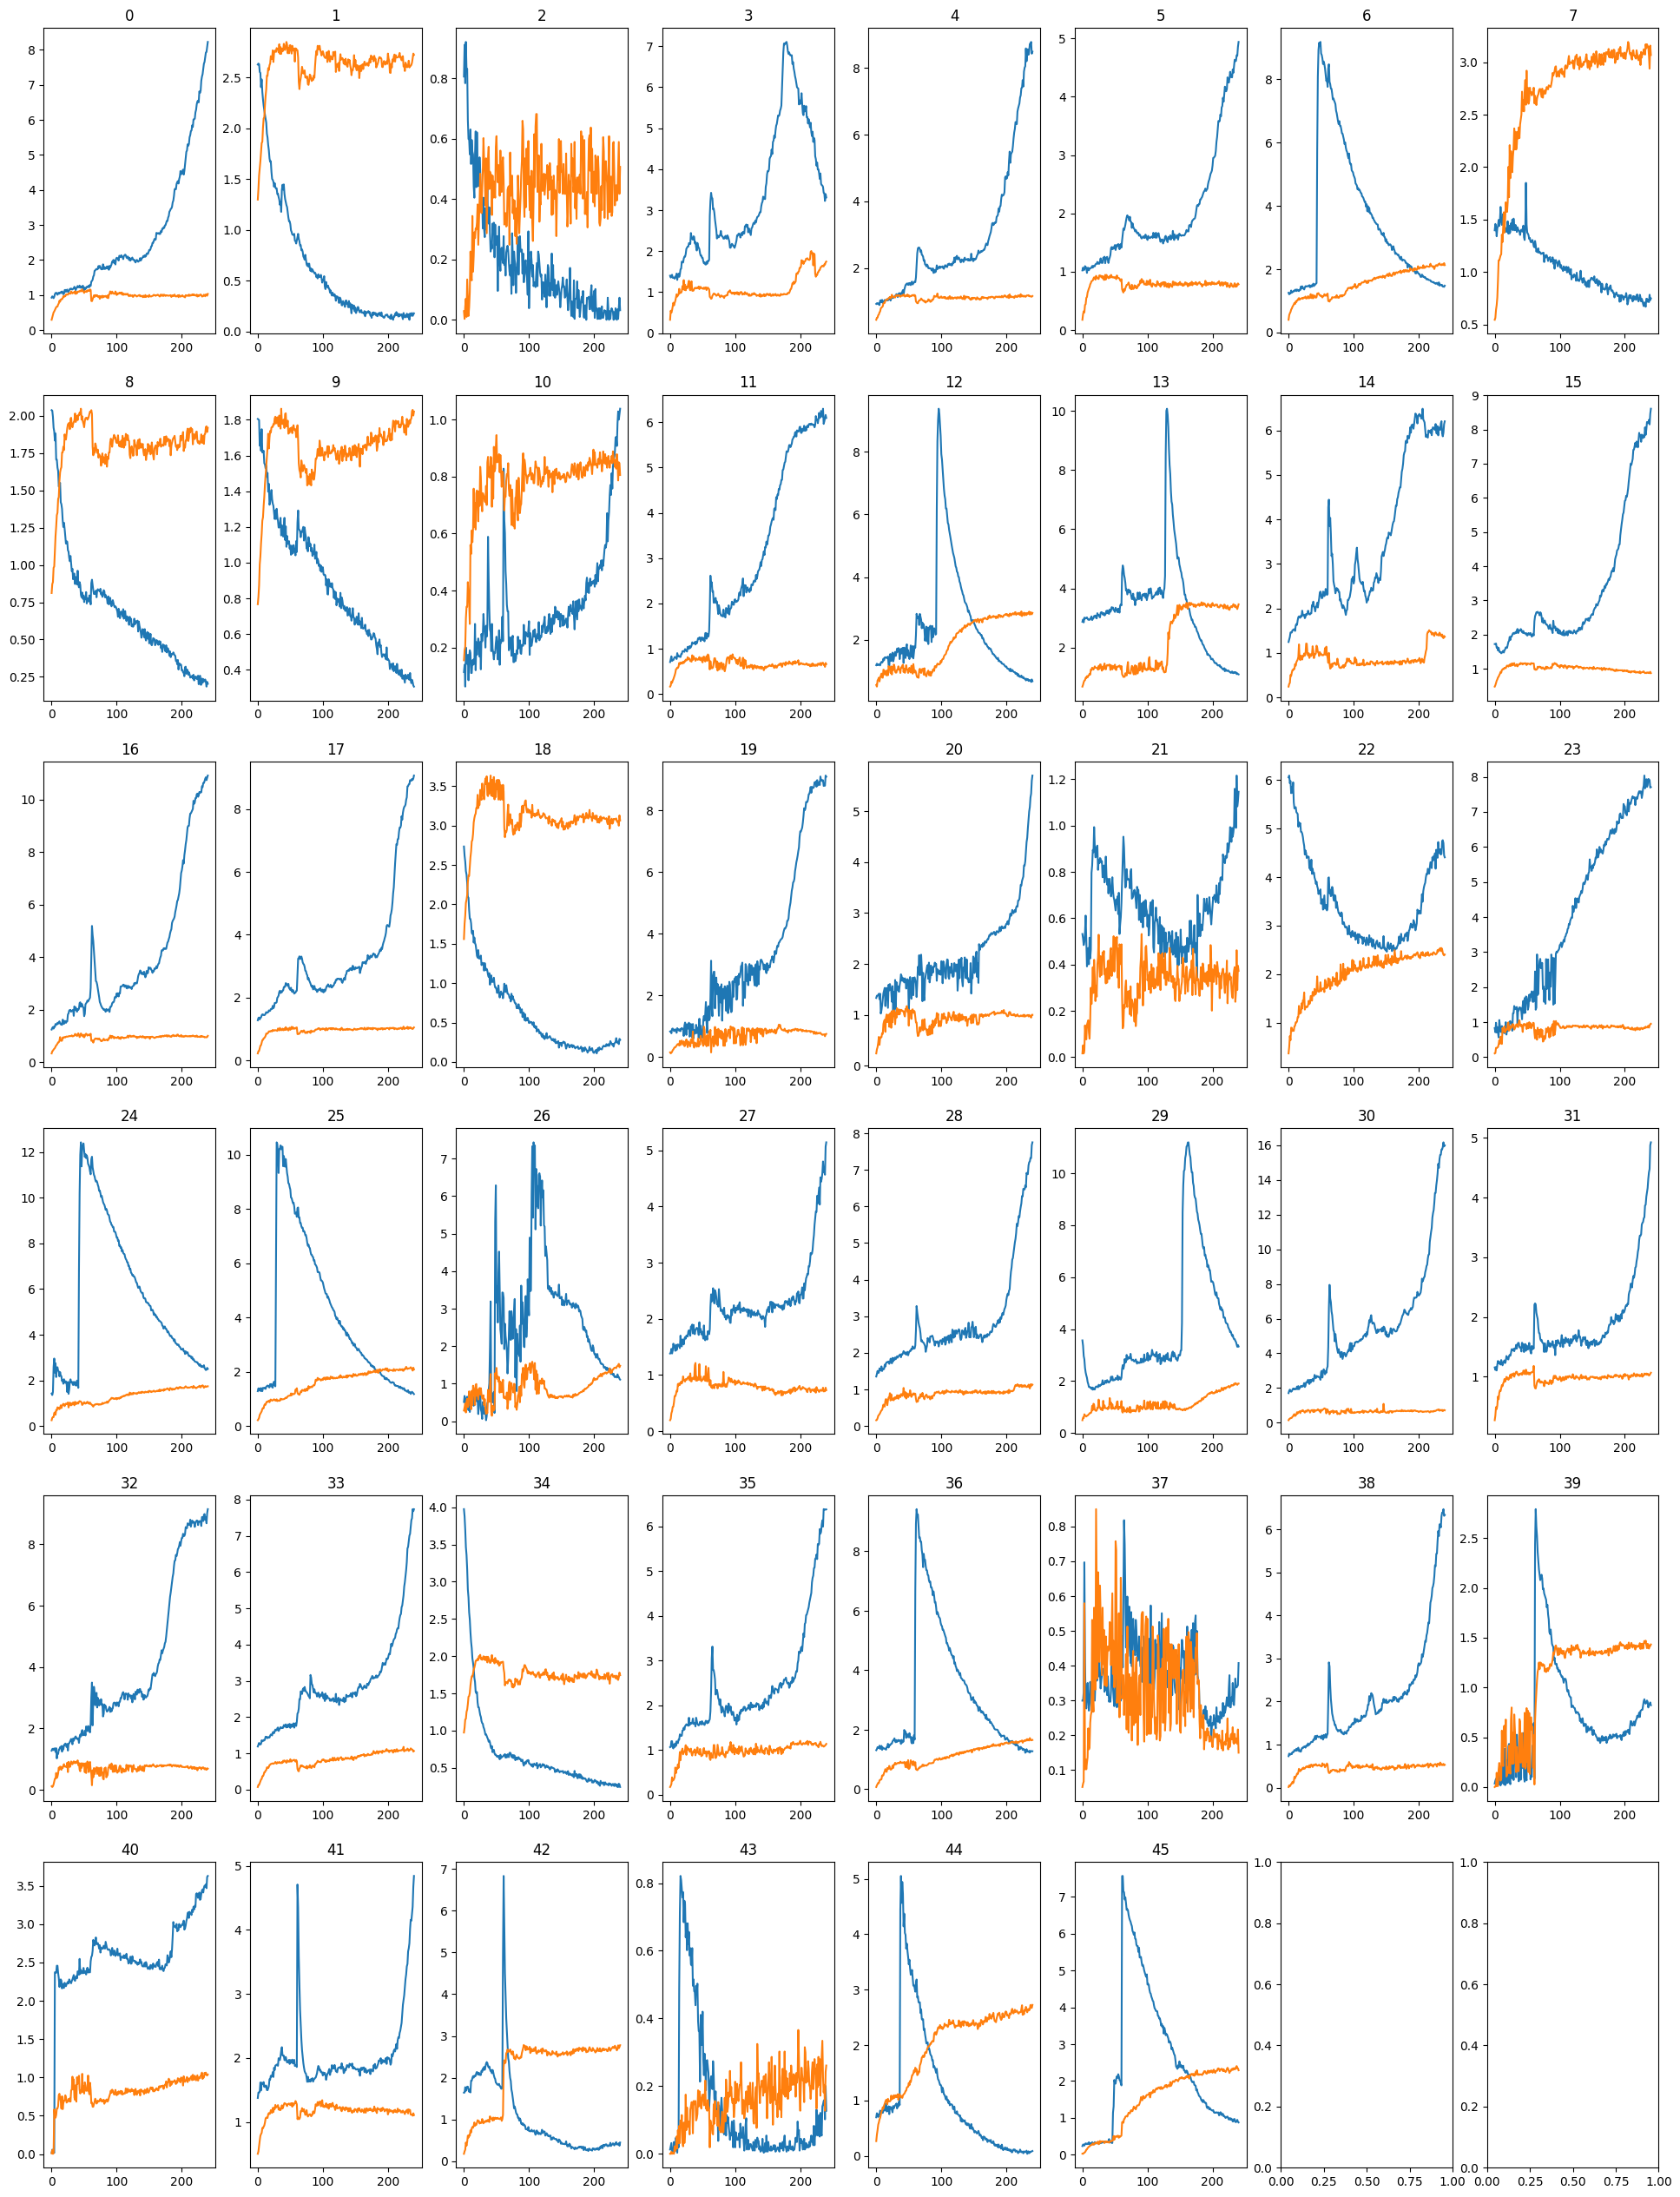

In [58]:
fluo_stats, membrana_stats, exponencial = get_all_fluo_stats(centros_cabeza_promedio,canal_fluo,canal_membrana)

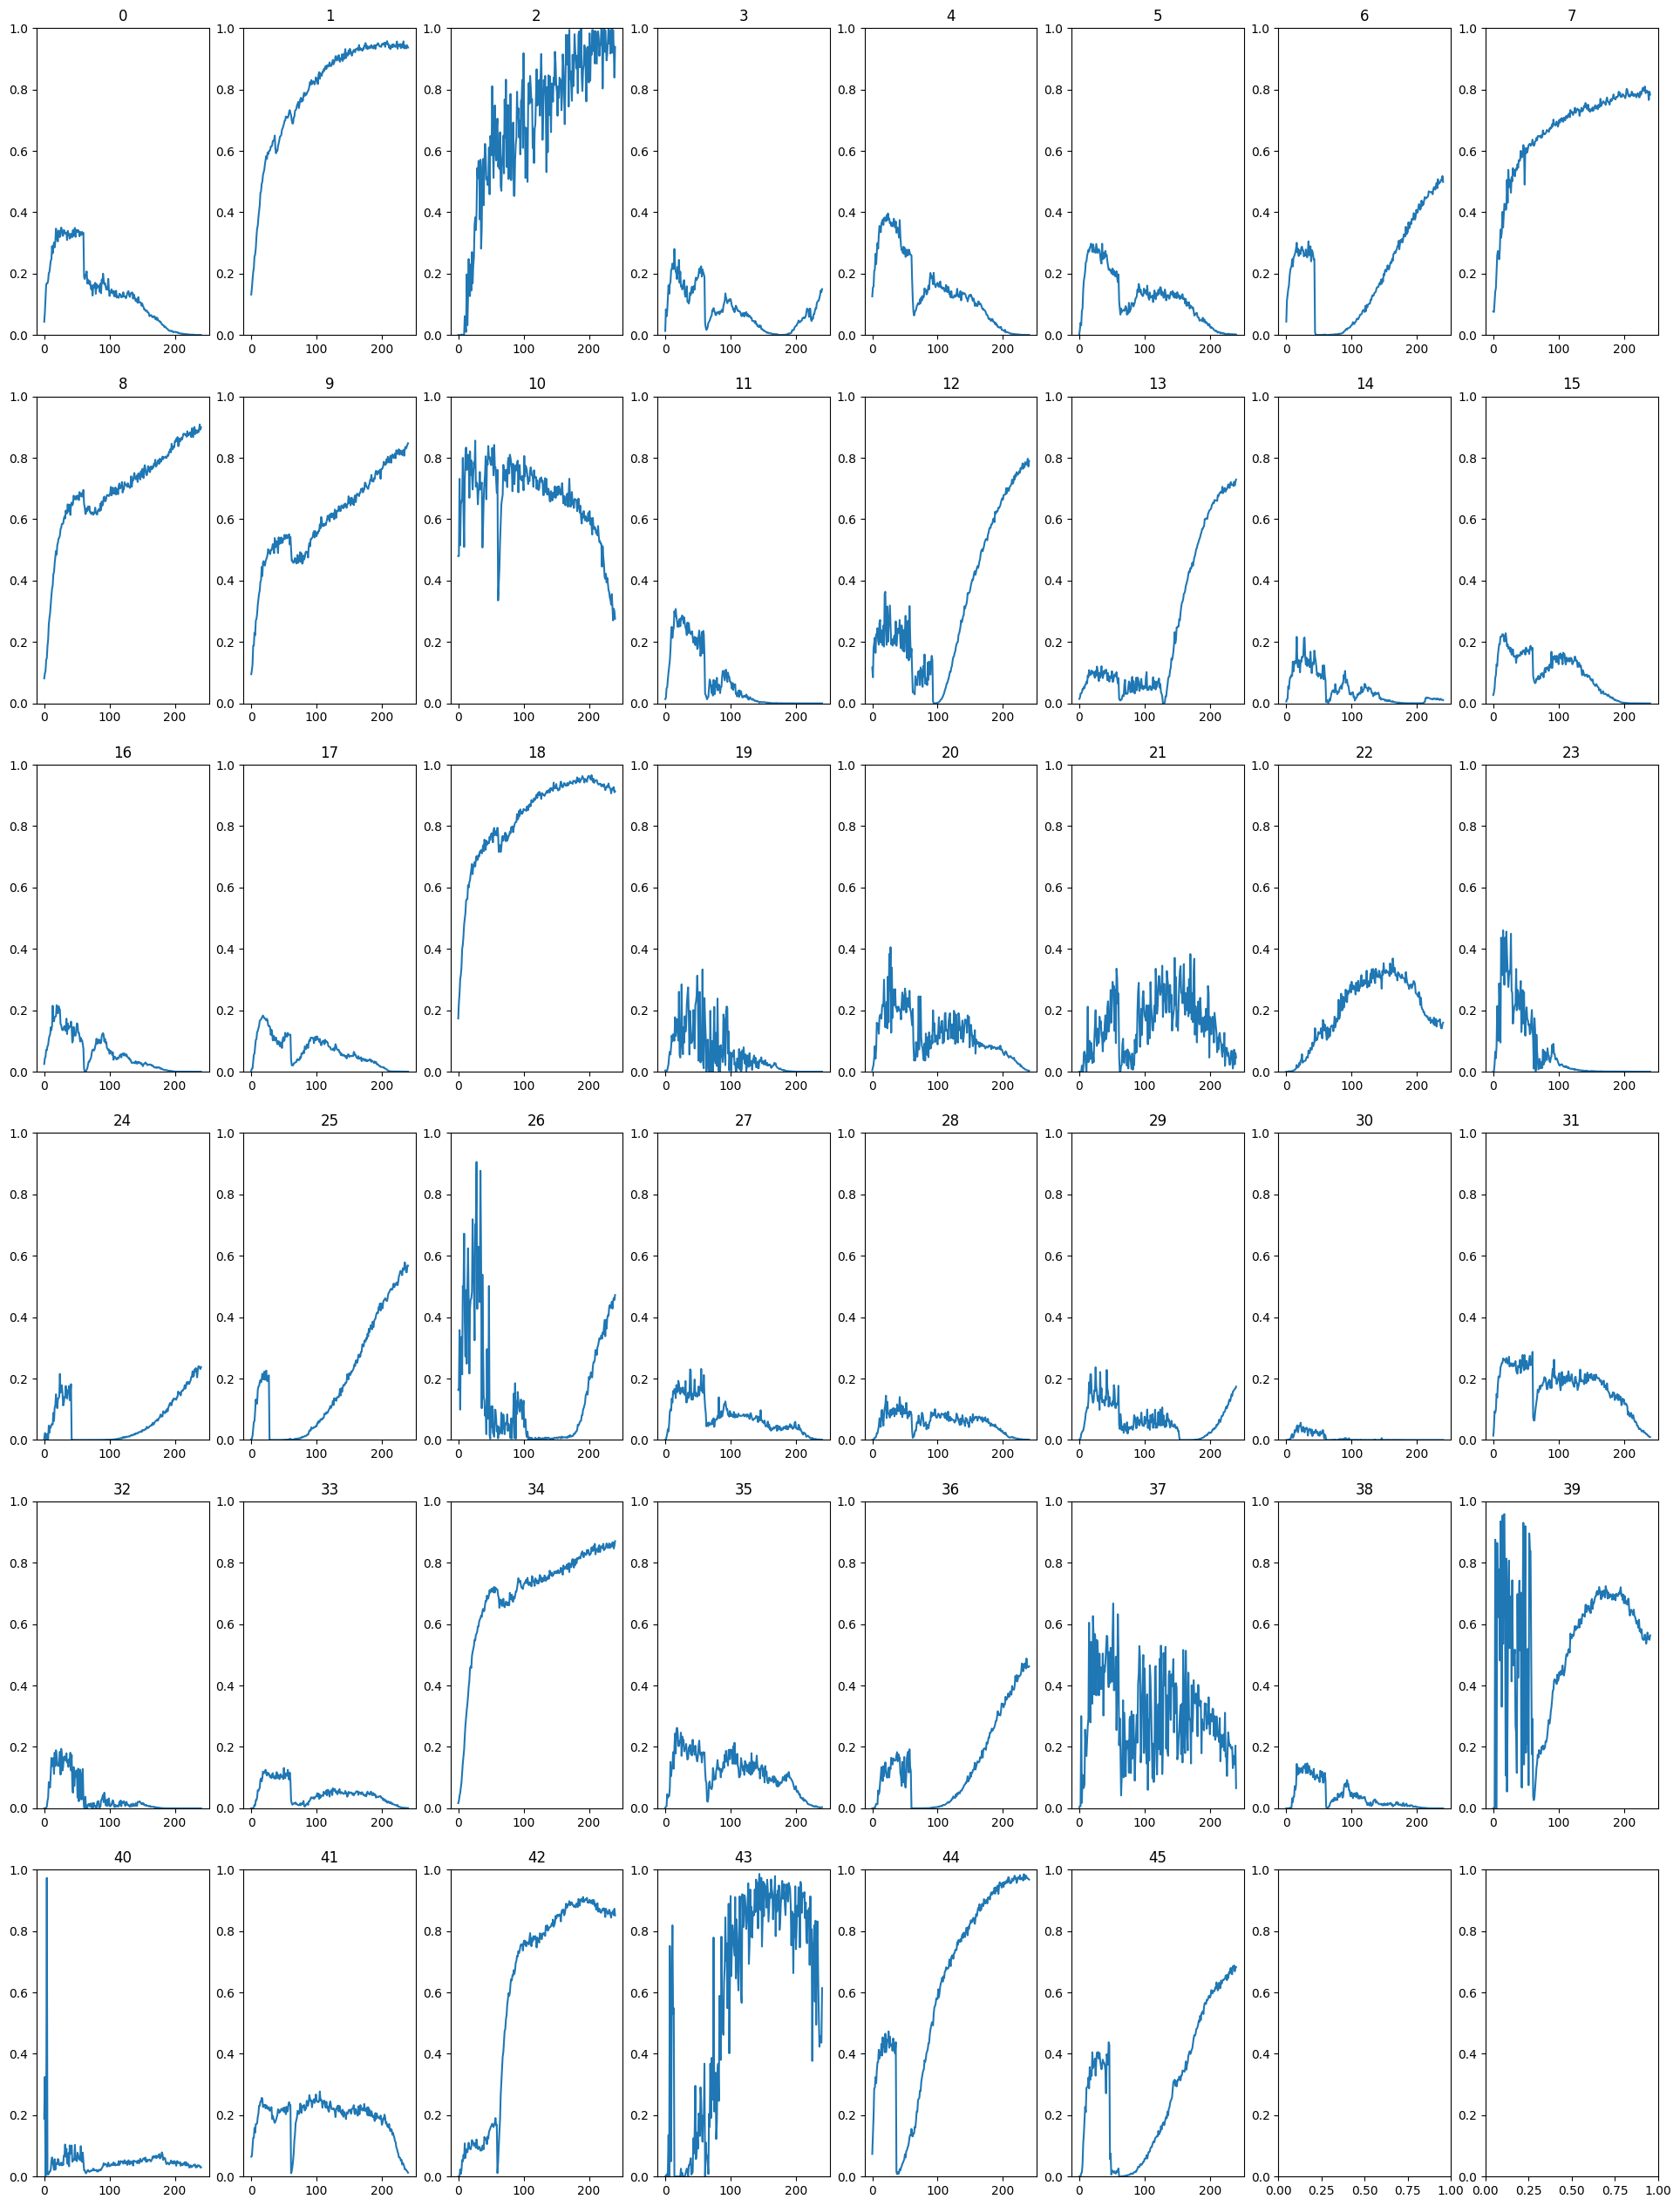

In [59]:
fluo_stats, membrana_stats, exponencial  = get_all_fluo_stats(centros_cabeza_promedio,canal_fluo,canal_membrana,plot=False,plot_indice_RA=True)

# Clasificar Reaccion vs NoReaccion

In [60]:
def obtener_etiquetas(exponencial,th):
  labels = []
  for j in range(exponencial.shape[1]):
    if np.mean(exponencial[-14:,j])>th:
      labels.append(1)
    else:
      labels.append(0)
  return np.array(labels)

In [61]:
# Porcentaje de reaccion

elipses_totales = exponencial.shape[1]
elipses_reaccion = np.sum(obtener_etiquetas(exponencial,th=THRESHOLD_AR))
porc_reac = 100*elipses_reaccion/elipses_totales

print(f'Se encontraron un total de {elipses_totales} elipses')
print(f'De estas, {elipses_reaccion} elipses reaccionaron. Esto representa un {porc_reac:.0f}%')

Se encontraron un total de 46 elipses
De estas, 15 elipses reaccionaron. Esto representa un 33%


In [63]:
# Cuales esperma reaccionaron

labels = obtener_etiquetas(exponencial,th=THRESHOLD_AR)
idx_reaccion = np.where(labels==1)[0]

print(f'Las elipses que reaccionaron son las de indice: {idx_reaccion}')

if PLOT_VIDEOS:
    animation_filtered = video_reaccion(centros_cabeza_promedio,canal_fluo,idx_reaccion)
    animation_filtered.ipython_display(fps = 10, loop = True, autoplay = True)




Las elipses que reaccionaron son las de indice: [ 1  2  7  8  9 12 13 18 25 34 39 42 43 44 45]


In [64]:
if PLOT_VIDEOS:
    animation_filtered = video_reaccion(centros_cabeza_promedio,canal_membrana,idx_reaccion)
    animation_filtered.ipython_display(fps = 10, loop = True, autoplay = True)
